Data Processing and Separation
==============================

In [2]:
!pip install librosa

In [3]:
import pandas as pd
import numpy as np
import librosa as lib
import IPython.display as ipd
import matplotlib.pyplot as plt

In [4]:
valid_data = pd.read_csv("../valid_data.csv")

# we need phone position, affect, file_path, then the local file path
valid_data["file_path"] = valid_data["file_name"].str.replace("/media/data/shout-data/", "/dataset/")
valid_data["file_path"] = valid_data["file_path"].str.replace(".wav", "")
valid_data["file_path"] = valid_data["file_path"].astype(str) + valid_data["chunk_name"].astype(str)

processingSet = valid_data[["affect", "file_path", "phone_position"]]

testSet = valid_data.sample(n=100, random_state=100)
testSet.to_csv("../test_set.csv")

trainingSet = valid_data.drop(testSet.index)
trainingSet.to_csv("../training_set.csv")

In [5]:
valid_data = pd.read_csv("../valid_data.csv")

# we need phone position, affect, file_path, then the local file path
valid_data["file_path"] = valid_data["file_name"].str.replace("/media/data/shout-data/", "../dataset/")
valid_data["file_path"] = valid_data["file_path"].str.replace(".wav", "")
valid_data["file_path"] = valid_data["file_path"].astype(str) + valid_data["chunk_name"].astype(str)

processingSet = valid_data[["affect", "file_path", "phone_position"]]
processingSet

,affect,file_path,phone_position
0,sadness,../dataset/shout_data_3afd7208-7987-4c73-8e01-...,Place phone on the opposite side of the room i...
1,neutral,../dataset/shout_data_ae6feb35-cf7a-4805-8d05-...,Hold your phone next to your face but with the...
2,neutral,../dataset/shout_data_fdb758a5-9c86-40f7-8870-...,Place phone on the opposite side of the room f...
3,neutral,../dataset/shout_data_fdb758a5-9c86-40f7-8870-...,Place phone on the opposite side of the room f...
4,disgust,../dataset/shout_data_739dbf1c-ec21-42db-9e49-...,Place phone 1-2 meters away face up on any sur...
...,...,...,...
3048,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...
3049,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...
3050,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...
3051,fear,../dataset/shout_data_d5d4e179-d411-4652-b80b-...,Place phone 1-2 meters away face down on a har...


Time Domain Feature Extraction
===================
https://www.youtube.com/watch?v=SRrQ_v-OOSg

https://www.youtube.com/watch?v=rlypsap6Wow

https://www.youtube.com/watch?v=EycaSbIRx-0

Time-domain features:
- Amplitude envelope 
- Root-mean-square energy 
- Zero-crossing rate

In [6]:
FRAME_SIZE = 512 # the size of the frame
HOP_LENGTH = 256 # the distance each frame jumps by
FRAME_LENGTH = 512 # length of a frame

def getFeatures(audioSignal, sample_rate):
    # duration of 1 sample
    oneSampleDuration = 1/sample_rate
    
    # duration of audio signal in seconds
    sampleDuration = oneSampleDuration*len(audioFile)
    
    ae, time = getAmplitudeEnvelope(audioSignal)
    rms = getRMS(audioSignal)
    zcr = getZCR(audioSignal)
    
    return time, ae, rms, zcr
    
def getAmplitudeEnvelope(audioSignal):
    amplitudeEnvelope = []
    
    for i in range(0, len(audioSignal), HOP_LENGTH):
        currentFrameAE = max(audioSignal[i:i+FRAME_SIZE])
        amplitudeEnvelope.append(currentFrameAE)
        
    amplitudeEnvelope = np.array(amplitudeEnvelope)
    amplitudeFrames = range(0, amplitudeEnvelope.size)
    time = librosa.frames_to_time(amplitudeFrames, hop_length=HOP_LENGTH)
    
    return amplitudeEnvelope, time
    
def getRMS(audioSignal):
    rms = []
    for i in range(0, len(audioSignal), HOP_LENGTH):
        rms_current = np.sqrt(np.sum(audioSignal[i:i+FRAME_LENGTH]**2) / FRAME_LENGTH)
        rms.append(rms_current)
    return rms

def getZCR(audioSignal):
    return lib.feature.zero_crossing_rate(audioSignal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]


In [7]:
ipd.Audio(processingSet["file_path"][0])

ValueError: rate must be specified when data is a numpy array or list of audio samples.

audio clip duration: 3.6560090702947847
audio envelope length: 315
RMSE length: 315
ZCR length: 315


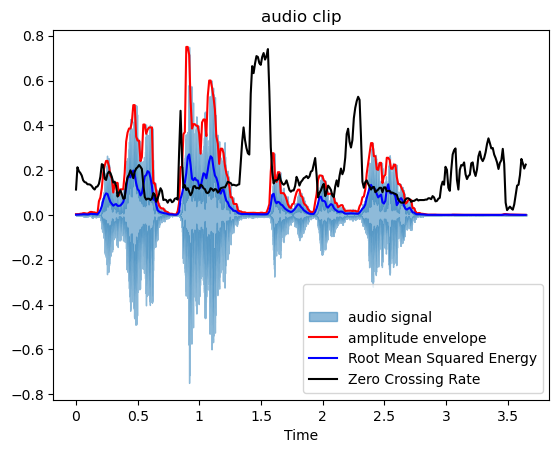

In [ ]:
audioFile, sample_rate = lib.load(processingSet["file_path"][0])

audioClipDuration = len(audioFile) / sample_rate

print("audio clip duration: {}".format(audioClipDuration))

(ae_audio, time) = getAmplitudeEnvelope(audioFile)
print("audio envelope length: {}".format(len(ae_audio)))

rms_audio = getRMS(audioFile)
print("RMSE length: {}".format(len(rms_audio)))

zcr_audio = getZCR(audioFile)
print("ZCR length: {}".format(len(zcr_audio)))

lib.display.waveshow(audioFile, alpha = 0.5)
plt.title("audio clip")
plt.plot(time, ae_audio, color="r")
plt.plot(time, rms_audio, color = 'b')
plt.plot(time, zcr_audio, color = 'k')

plt.legend(["", "audio signal", "amplitude envelope", "Root Mean Squared Energy", "Zero Crossing Rate"])

In [ ]:
# audio processing and getting features
zeroCrossingRateList = []
amplitudeEnvelopeList = []
rootMeanSquareEnergyList = []
timings = []

for fileDir in processingSet["file_path"]:
    audioFile, sample_rate = lib.load(fileDir)
    time, ae, rmse, zcr = getFeatures(audioFile, sample_rate)
    zeroCrossingRateList.append(zcr)
    amplitudeEnvelopeList.append(ae)
    rootMeanSquareEnergyList.append(rmse)
    timings.append(time)
    
processingSet["Timings"] = timings
processingSet["Amplitude_Envelope"] = amplitudeEnvelopeList
processingSet["Root_Mean_Square_Energy"] = rootMeanSquareEnergyList
processingSet["Zero-Crossing Rate"] = zeroCrossingRateList

processingSet

C:\Users\Andre\AppData\Local\Temp\ipykernel_15468\600433389.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processingSet["Timings"] = timings
C:\Users\Andre\AppData\Local\Temp\ipykernel_15468\600433389.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processingSet["Amplitude_Envelope"] = amplitudeEnvelopeList
C:\Users\Andre\AppData\Local\Temp\ipykernel_15468\600433389.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,affect,file_path,phone_position,Timings,Amplitude_Envelope,Root_Mean_Square_Energy,Zero-Crossing Rate
0,sadness,../dataset/shout_data_3afd7208-7987-4c73-8e01-...,Place phone on the opposite side of the room i...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0032839072, 0.0032839072, 0.00350599, 0.005...","[0.0009506898613838954, 0.0011638607032441442,...","[0.11328125, 0.212890625, 0.1953125, 0.1875, 0..."
1,neutral,../dataset/shout_data_ae6feb35-cf7a-4805-8d05-...,Hold your phone next to your face but with the...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.004194142, 0.0051562022, 0.0051562022, 0.00...","[0.0009502910563931367, 0.0012563294132073518,...","[0.109375, 0.171875, 0.125, 0.1328125, 0.19726..."
2,neutral,../dataset/shout_data_fdb758a5-9c86-40f7-8870-...,Place phone on the opposite side of the room f...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0008344989, 0.00081817346, 0.0005687686, 0....","[0.00032637071745313475, 0.0002471612373085063...","[0.0390625, 0.091796875, 0.115234375, 0.123046..."
3,neutral,../dataset/shout_data_fdb758a5-9c86-40f7-8870-...,Place phone on the opposite side of the room f...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0005062038, 0.00051106384, 0.00051106384, 0...","[0.00023130468470567851, 0.0002383317342184948...","[0.06640625, 0.130859375, 0.158203125, 0.20703..."
4,disgust,../dataset/shout_data_739dbf1c-ec21-42db-9e49-...,Place phone 1-2 meters away face up on any sur...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0036947224, 0.002895405, 0.00268817, 0.0037...","[0.0014018053878398194, 0.0012150504599213723,...","[0.15234375, 0.287109375, 0.265625, 0.24023437..."
...,...,...,...,...,...,...,...
3048,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.03807035, 0.12672687, 0.284319, 0.284319, 0...","[0.013799129414964393, 0.02955565602094313, 0....","[0.09765625, 0.27734375, 0.298828125, 0.160156..."
3049,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.00393799, 0.0024600597, 0.0022432208, 0.001...","[0.001560069814587179, 0.001250658694096706, 0...","[0.04296875, 0.072265625, 0.07421875, 0.095703..."
3050,sadness,../dataset/shout_data_f8d1719f-8a4b-4d7a-a2a7-...,Place phone as far away as possible while on o...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.010004332, 0.013232408, 0.055084866, 0.0927...","[0.0031485464759446113, 0.004680925972593484, ...","[0.30859375, 0.5546875, 0.455078125, 0.328125,..."
3051,fear,../dataset/shout_data_d5d4e179-d411-4652-b80b-...,Place phone 1-2 meters away face down on a har...,"[0.0, 0.011609977324263039, 0.0232199546485260...","[0.0006427922, 6.995505e-05, 0.002614112, 0.07...","[0.00014240172739994383, 1.3349751781022235e-0...","[0.12890625, 0.42578125, 0.669921875, 0.539062..."


Frequency Domain Feature Extraction
=========
https://www.youtube.com/watch?v=3-bjAoAxQ9o

https://www.youtube.com/watch?v=8UJ8ZDR7yUs

https://www.youtube.com/watch?v=j6NTatoi928

Time-domain features:
- Spectral Centroid
- Bandwidth
- Band Energy Ratio

In [20]:
def calc_sfb(spec, freq, sr):
    freq_range = sr/2
    freq_delta = freq_range / spec.shape[0]
    return int(np.floor(freq / freq_delta))

In [100]:
def calc_ber(spec, freq, sr):
    sfb = calc_sfb(spec, freq, sr)
    pSpec = np.abs(spec) ** 2
    pSpec = pSpec.T
    ber = []

    for freqs in pSpec:
        sum_low = np.sum(freqs[:sfb])
        sum_high = np.sum(freqs[sfb:])
        ber_current = sum_low/sum_high
        ber.append(ber_current)

    return np.array(ber)

In [105]:
file = "C:\\Users\\ellis\\Desktop\\School\\AI\\shout-data\\shout-data\\shout_data_00a0fb59-49f0-40e1-8481-6a334c65b126\\final\\chunk31.wav"
audio, sample_rate = lib.load(file)
audio_spec = lib.stft(audio, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
centroid = lib.feature.spectral_centroid(y=audio, sr=sample_rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
bandwidth = lib.feature.spectral_bandwidth(y=audio, sr=sample_rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
sfb = calc_sfb(audio_spec, 2000, 22050)
ber = calc_ber(audio_spec, 2000, sample_rate)

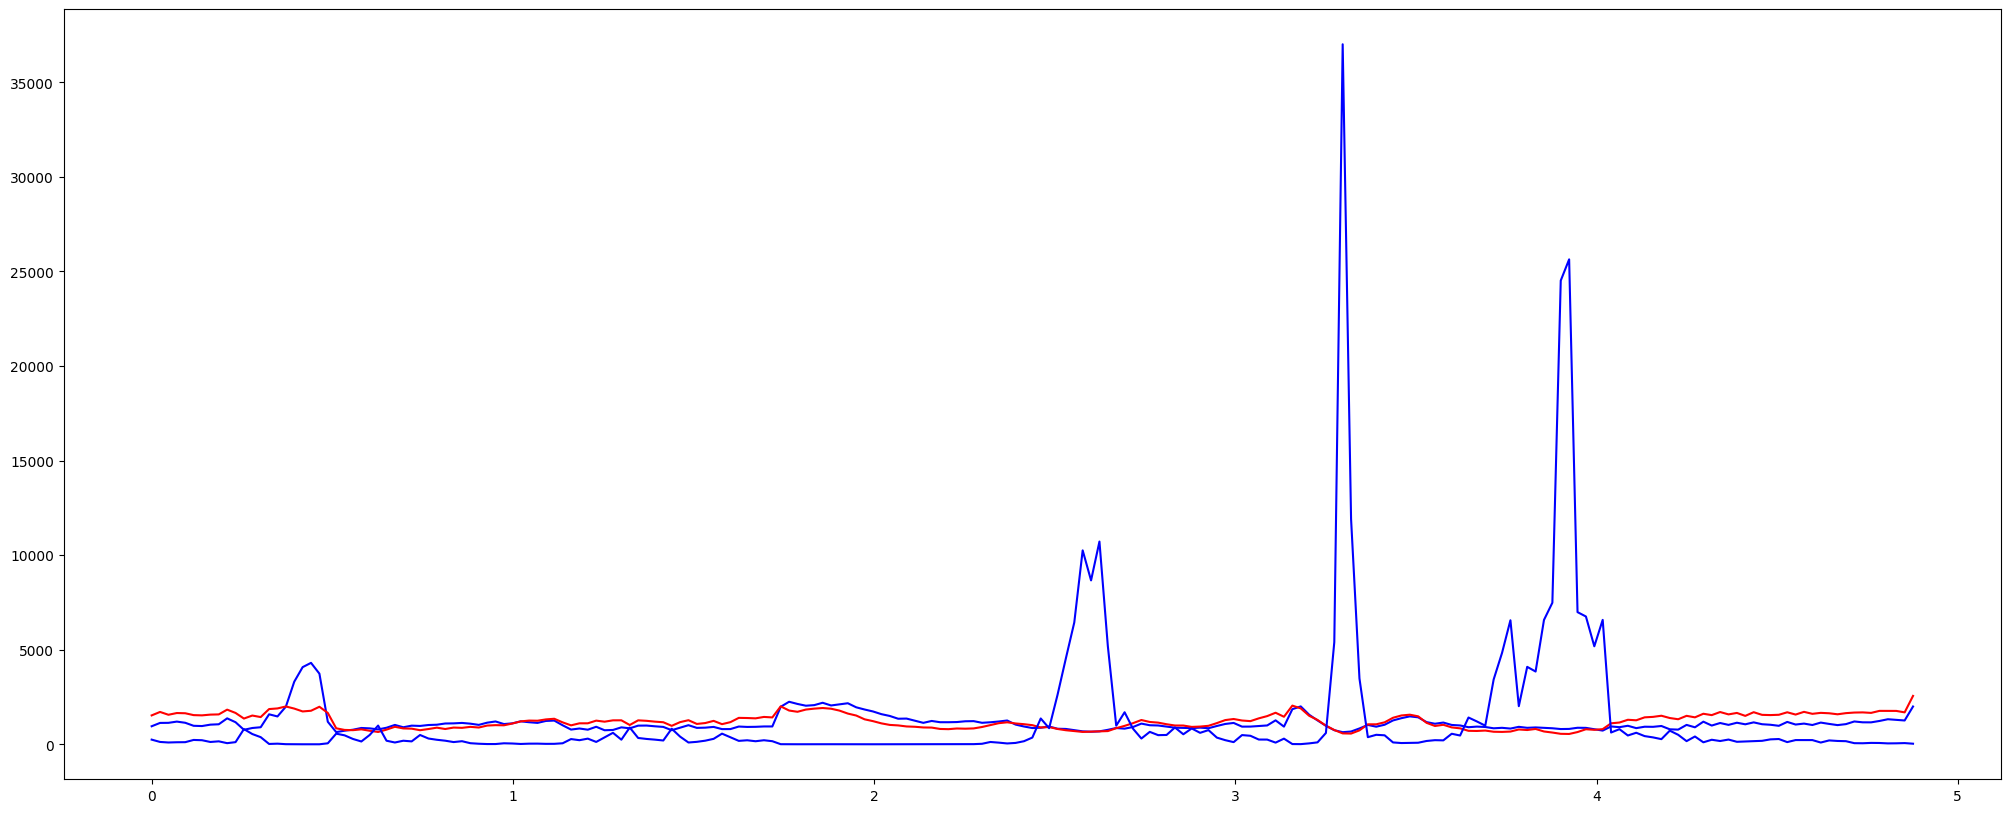

In [107]:
frames = range(len(centroid))
plt.figure(figsize=(25, 10))
plt.plot(lib.frames_to_time(frames), centroid, color='b')
plt.plot(lib.frames_to_time(frames), bandwidth, color='r')
frames = range(len(ber))
plt.figure(figsize=(25, 10))
plt.plot(lib.frames_to_time(frames), ber, color='b')